#### Visualize the saved dataset for quality control

In [12]:
import sys
import numpy as np
import tensorflow.compat.v1 as tf
%matplotlib inline
import matplotlib.pyplot as plt

In [13]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


##### Set the path to directory containing GANSim code of this case, since a dataset.py will be loaded

In [14]:
new_path = r'/home/users/suihong/11-GenerativeGeomodelling_GANs_MPS_Comparison/2DChannel/2_GANSimTraining/' 
sys.path.append(new_path)

#### Set the path to data directory; this directory includes two datasets: "trainingdata" and "testdata"

In [15]:
data_dir = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/PreparedDataset/'

### 1. Visualize test dataset with original resolutions

*if tfrecord_dir='TestData', then test dataset will be loaded; if tfrecord_dir = 'TrainingData', then training dataset will be loaded*

In [7]:
tf.InteractiveSession()

import dataset


test_set = dataset.load_dataset(data_dir=data_dir, verbose=True, tfrecord_dir='TestData', 
                                 cond_label = True, cond_well = True, cond_prob = True,
                                 well_enlarge = False, shuffle_mb = 0, prefetch_mb = 0)

# Note: labels are from -1 to 1
test_dict = test_set.get_minibatch_np(minibatch_size = 1000, lod = 0)  
facies_test = test_dict['real']
labels_test = test_dict['label']
probimgs_test = test_dict['prob']
wellfaciesimgs_test = test_dict['well']

print("Facies images shape:", facies_test.shape)
print("Labels shape:", labels_test.shape)
print("Probability maps shape:", probimgs_test.shape)
print("Well facies shape:", wellfaciesimgs_test.shape)

Streaming data using dataset.TFRecordDataset...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.
Dataset shape = [1, 64, 64]
Dynamic range = [0, 2]
Label size    = 0
Facies images shape: (1000, 1, 64, 64)
Labels shape: (1000, 34)
Probability maps shape: (1000, 2, 64, 64)
Well facies shape: (1000, 1, 64, 64)


#### Denormalize global features

In [10]:
# Extract orientation category from one-hot encoding (first 30 columns)
orit_one_hot = labels_test[:, :30]
orit_class = np.argmax(orit_one_hot, axis=1)

# Extract and denormalize mud proportion
mudprop = labels_test[:, 30]  # Normalized to [-1, 1]
mudprop = (mudprop / 2 + 0.5) * 0.8037 + 0.1677  # Original range: ~[0.1677, 0.9714]

# Extract and denormalize channel width
width = labels_test[:, 31]  # Normalized to [-1, 1]
width = (width / 2 + 0.5) * 8 + 27  # Original range: [27, 35]

# Extract and denormalize channel wavelength
wvl = labels_test[:, 32]  # Normalized to [-1, 1]
wvl = (wvl / 2 + 0.5) * 63 + 100  # Original range: [100, 163]

# Extract and denormalize channel amplitude
amplt = labels_test[:, 33]  # Normalized to [-1, 1]
amplt = (amplt / 2 + 0.5) * 104 + 7  # Original range: [7, 111]


Orientation Class Mapping (each class spans 6 degrees):

Class  0: -90 ~ -84
Class  1: -84 ~ -78
Class  2: -78 ~ -72
Class  3: -72 ~ -66
Class  4: -66 ~ -60
Class  5: -60 ~ -54
Class  6: -54 ~ -48
Class  7: -48 ~ -42
Class  8: -42 ~ -36
Class  9: -36 ~ -30
Class 10: -30 ~ -24
Class 11: -24 ~ -18
Class 12: -18 ~ -12
Class 13: -12 ~  -6
Class 14:  -6 ~   0
Class 15:   0 ~   6
Class 16:   6 ~  12
Class 17:  12 ~  18
Class 18:  18 ~  24
Class 19:  24 ~  30
Class 20:  30 ~  36
Class 21:  36 ~  42
Class 22:  42 ~  48
Class 23:  48 ~  54
Class 24:  54 ~  60
Class 25:  60 ~  66
Class 26:  66 ~  72
Class 27:  72 ~  78
Class 28:  78 ~  84
Class 29:  84 ~  90

#### Display obtained dataset

In [11]:
### Enlarge areas of well points only for better display ###

def enlarge(well_facies):
    ### Enlarge areas of well points into 4 x 4 as inputs
    with tf.device('/gpu:0'):
        well_facies = tf.cast(well_facies, tf.float32)
        well_facies_enlarge = tf.nn.max_pool(well_facies, ksize = [1,1,3,3], strides=[1,1,1,1], padding='SAME', data_format='NCHW') 
    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        well_points_el = sess.run(well_facies_enlarge) 
    return well_points_el

wellfacies_onechannel = enlarge(wellfaciesimgs_test)
wellfacies_onechannel_mask = np.ma.masked_where(wellfacies_onechannel == 0, wellfacies_onechannel)
cmap_well = plt.cm.viridis  
cmap_well.set_bad(color='white')

In [12]:
facies_test.shape

(1000, 1, 64, 64)

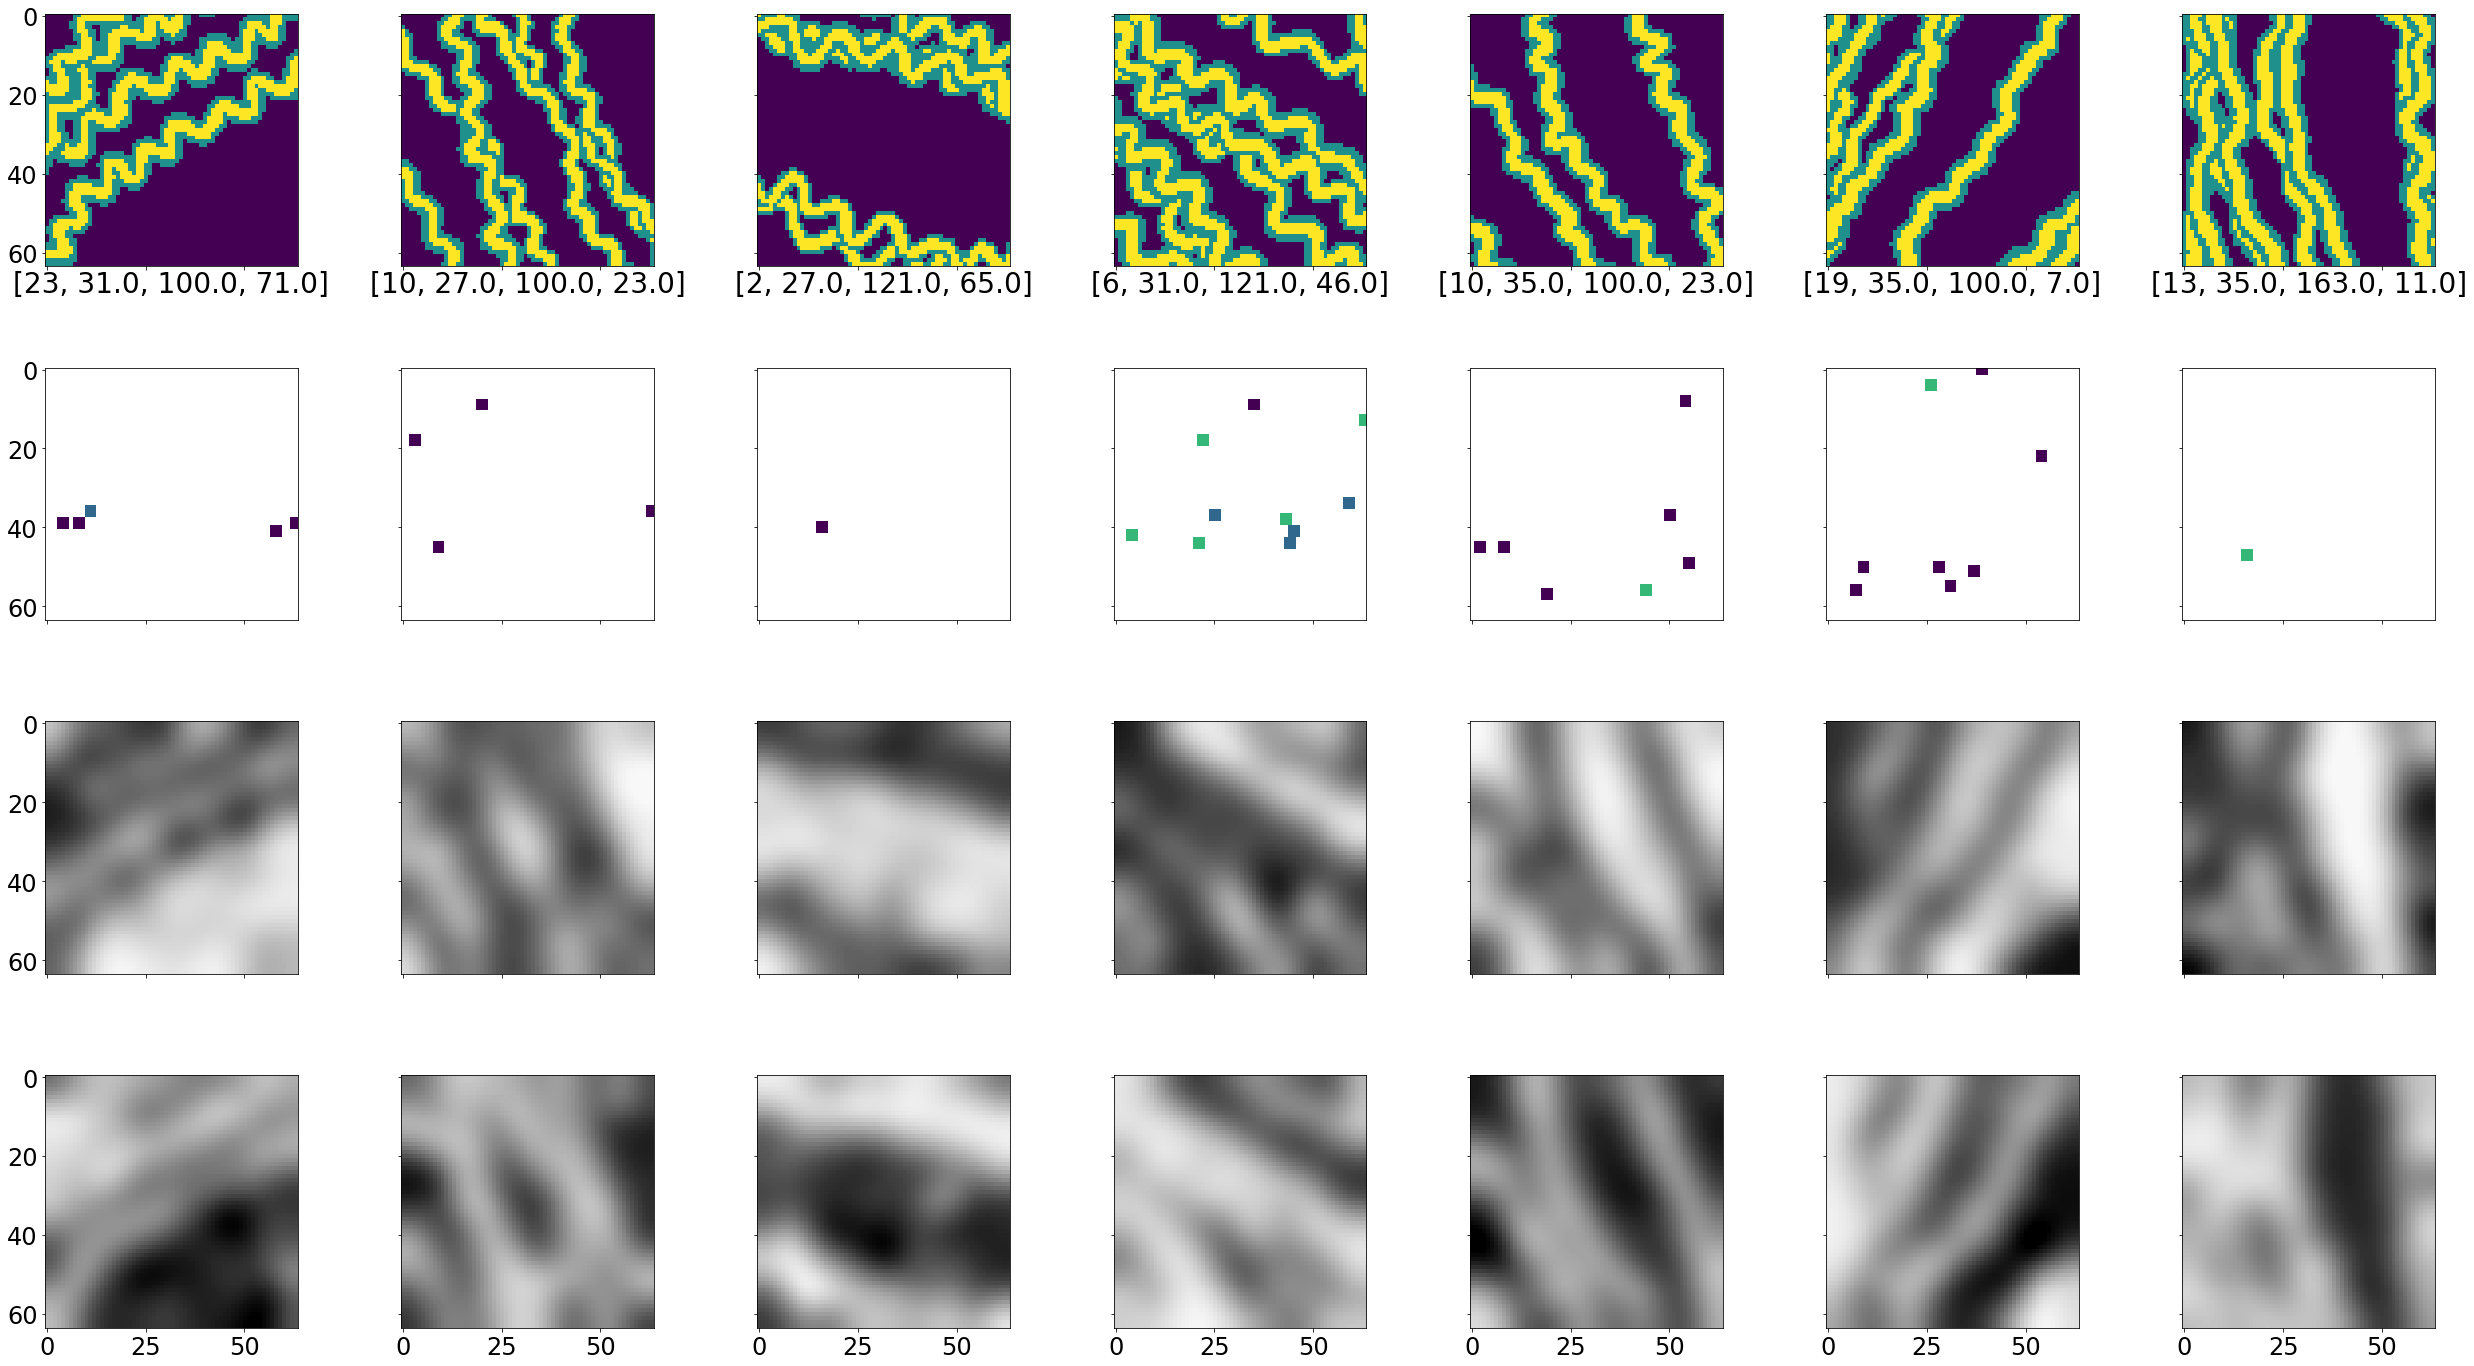

In [18]:
# Set larger font for readability
plt.rcParams.update({'font.size': 24})

# Create 4-row × 7-column figure layout
fig, ax = plt.subplots(4, 7, sharex='col', sharey='row')
fig.set_size_inches(35, 20, forward=True)

# Loop through 7 test examples (index 1 to 7)
for i in range(1, 8):
    # Plot facies map
    ax[0, i-1].imshow(facies_test[i, 0])
    
    # Get denormalized labels
    orient = int(orit_class[i])
    width_val = round(width[i], 1)
    wvl_val = round(wvl[i], 1)
    amplt_val = round(amplt[i], 1)
    
    # Set label as: [OrientClass, Width, Wavelength, Amplitude]
    ax[0, i-1].set_xlabel(
        f"[{orient}, {width_val}, {wvl_val}, {amplt_val}]",
        fontsize=28
    )

# Plot well facies
for i in range(1, 8):
    ax[1, i-1].imshow(wellfacies_onechannel_mask[i, 0], cmap=cmap_well, vmin=1, vmax=4)

# Plot channel probability
for i in range(1, 8):
    ax[2, i-1].imshow(probimgs_test[i, 0].astype(np.float32), vmin=0, vmax=0.7, cmap='gray_r')

# Plot mud probability
for i in range(1, 8):
    ax[3, i-1].imshow(probimgs_test[i, 1].astype(np.float32), vmin=0, vmax=0.7, cmap='gray_r')

# Save figure (optional)
# plt.savefig(data_dir + "Training_data_examples_channel_case.png", dpi=200)

plt.tight_layout()
plt.show()


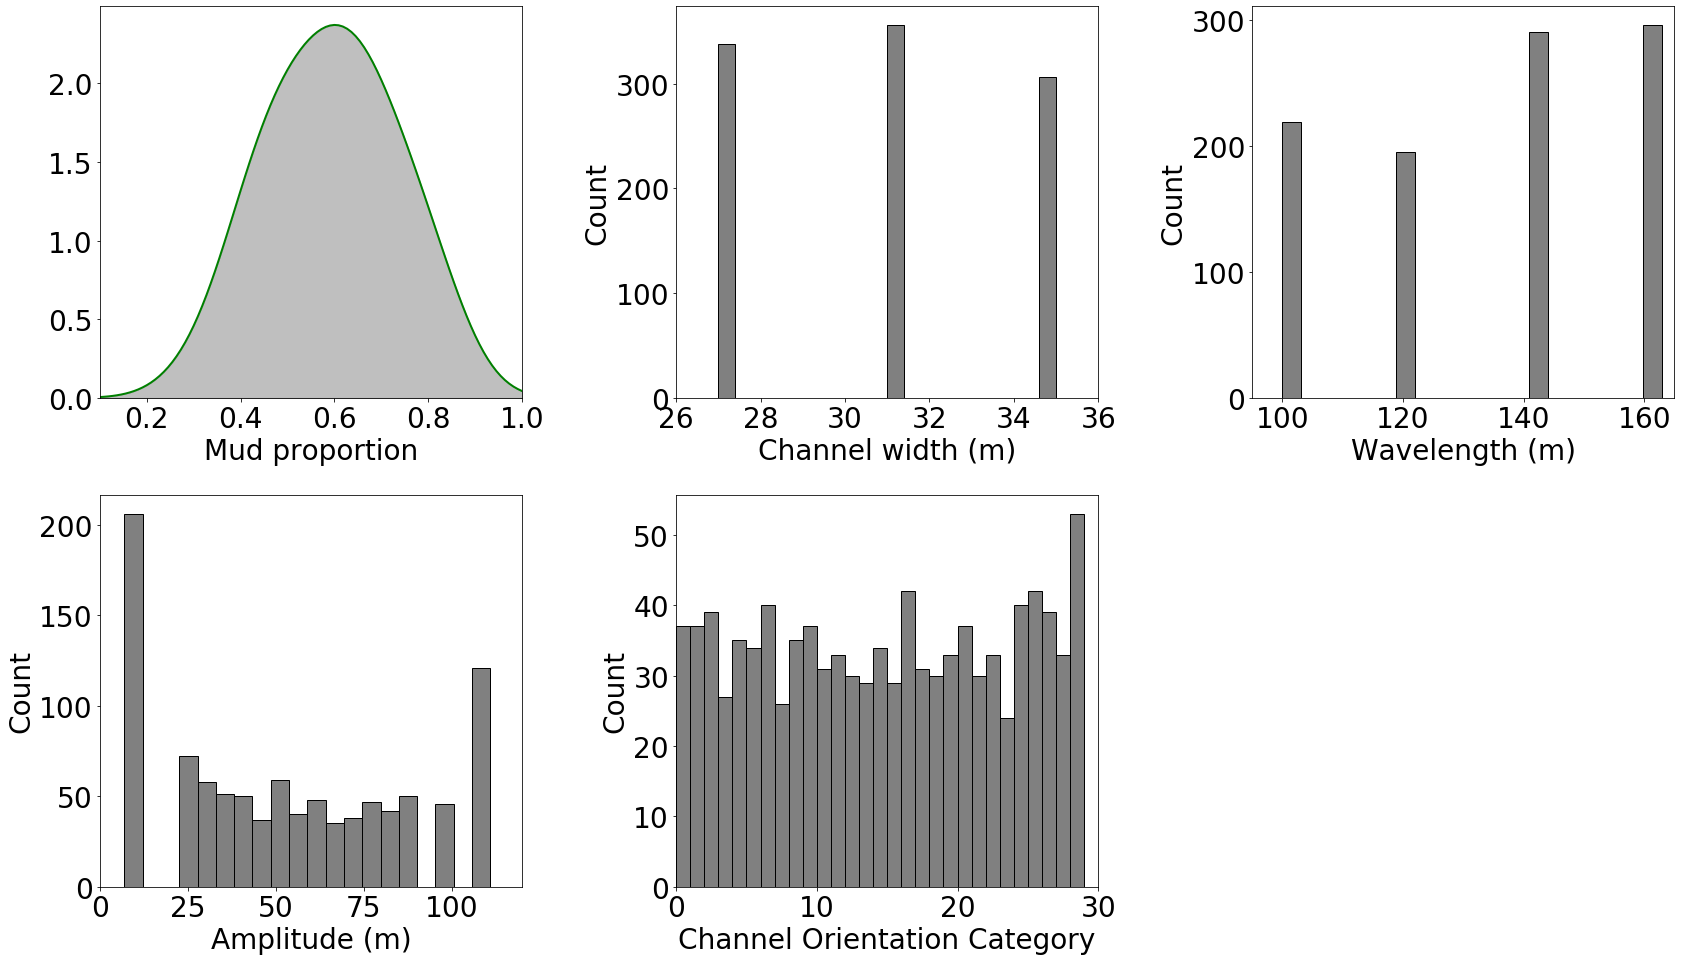

In [24]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np

plt.rcParams.update({'font.size': 28})

fig, ax = plt.subplots(2, 3)
fig.set_size_inches(24, 14, forward=True)

# ---------------------- Mud Proportion (Smoothed) ----------------------
x_range = np.linspace(0.1, 1.0, 100)
kde = gaussian_kde(mudprop, bw_method=0.5)
pdf_values = kde(x_range)

ax[0, 0].plot(x_range, pdf_values, 'g', linewidth=2, label='Mud proportion')
ax[0, 0].fill_between(x_range, pdf_values, color='gray', alpha=0.5)
ax[0, 0].set_ylim(bottom=0)
ax[0, 0].set_xlim(0.1, 1.0)
ax[0, 0].set_xlabel('Mud proportion')

# ---------------------- Channel Width (Histogram) ----------------------
ax[0, 1].hist(width, bins=20, color='gray', edgecolor='black')
ax[0, 1].set_xlim(26, 36)
ax[0, 1].set_xlabel('Channel width (m)')
ax[0, 1].set_ylabel('Count')

# ---------------------- Wavelength (Histogram) ----------------------
ax[0, 2].hist(wvl, bins=20, color='gray', edgecolor='black')
ax[0, 2].set_xlim(95, 165)
ax[0, 2].set_xlabel('Wavelength (m)')
ax[0, 2].set_ylabel('Count')

# ---------------------- Amplitude (Histogram) ----------------------
ax[1, 0].hist(amplt, bins=20, color='gray', edgecolor='black')
ax[1, 0].set_xlim(0, 120)
ax[1, 0].set_xlabel('Amplitude (m)')
ax[1, 0].set_ylabel('Count')

# ---------------------- Orientation (Histogram from Orientation Category) ----------------------
ax[1, 1].hist(orit_class, bins=np.arange(0, 30, 1), color='gray', edgecolor='black')
ax[1, 1].set_xlim(0, 30)
ax[1, 1].set_xlabel('Channel Orientation Category')
ax[1, 1].set_ylabel('Count')

# ---------------------- Empty plot slot ----------------------
ax[1, 2].axis('off')

# Final layout
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.tight_layout()

# Save figure (optional)
# plt.savefig(data_dir + "ChannelCase_HybridGlobalFeaturePlots.png", dpi=100)

plt.show()


### 2. Visualize test dataset with coarser resolutions (16x16)

*if tfrecord_dir='TestData', then test dataset will be loaded; if tfrecord_dir = 'TrainingData', then training dataset will be loaded*

In [25]:
tf.InteractiveSession()

import dataset


test_set = dataset.load_dataset(data_dir=data_dir, verbose=True, tfrecord_dir='TestData', 
                                 cond_label = True, cond_well = True, cond_prob = True,
                                 well_enlarge = False, shuffle_mb = 0, prefetch_mb = 0)

# Note: labels are from -1 to 1
test_dict = test_set.get_minibatch_np(minibatch_size = 1000, lod = 2)  
facies_test = test_dict['real']
labels_test = test_dict['label']
probimgs_test = test_dict['prob']
wellfaciesimgs_test = test_dict['well']

print("Facies images shape:", facies_test.shape)
print("Labels shape:", labels_test.shape)
print("Probability maps shape:", probimgs_test.shape)
print("Well facies shape:", wellfaciesimgs_test.shape)

/share/software/user/open/py-tensorflow/2.6.2_py36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Streaming data using dataset.TFRecordDataset...
Dataset shape = [1, 64, 64]
Dynamic range = [0, 2]
Label size    = 0
Facies images shape: (1000, 1, 16, 16)
Labels shape: (1000, 34)
Probability maps shape: (1000, 2, 64, 64)
Well facies shape: (1000, 1, 64, 64)


#### Denormalize global features

In [26]:
# Extract orientation category from one-hot encoding (first 30 columns)
orit_one_hot = labels_test[:, :30]
orit_class = np.argmax(orit_one_hot, axis=1)

# Extract and denormalize mud proportion
mudprop = labels_test[:, 30]  # Normalized to [-1, 1]
mudprop = (mudprop / 2 + 0.5) * 0.8037 + 0.1677  # Original range: ~[0.1677, 0.9714]

# Extract and denormalize channel width
width = labels_test[:, 31]  # Normalized to [-1, 1]
width = (width / 2 + 0.5) * 8 + 27  # Original range: [27, 35]

# Extract and denormalize channel wavelength
wvl = labels_test[:, 32]  # Normalized to [-1, 1]
wvl = (wvl / 2 + 0.5) * 63 + 100  # Original range: [100, 163]

# Extract and denormalize channel amplitude
amplt = labels_test[:, 33]  # Normalized to [-1, 1]
amplt = (amplt / 2 + 0.5) * 104 + 7  # Original range: [7, 111]


#### Display obtained dataset

In [27]:
### Enlarge areas of well points only for better display ###

def enlarge(well_facies):
    ### Enlarge areas of well points into 4 x 4 as inputs
    with tf.device('/gpu:0'):
        well_facies = tf.cast(well_facies, tf.float32)
        well_facies_enlarge = tf.nn.max_pool(well_facies, ksize = [1,1,3,3], strides=[1,1,1,1], padding='SAME', data_format='NCHW') 
    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        well_points_el = sess.run(well_facies_enlarge) 
    return well_points_el

wellfacies_onechannel = enlarge(wellfaciesimgs_test)
wellfacies_onechannel_mask = np.ma.masked_where(wellfacies_onechannel == 0, wellfacies_onechannel)
cmap_well = plt.cm.viridis  
cmap_well.set_bad(color='white')

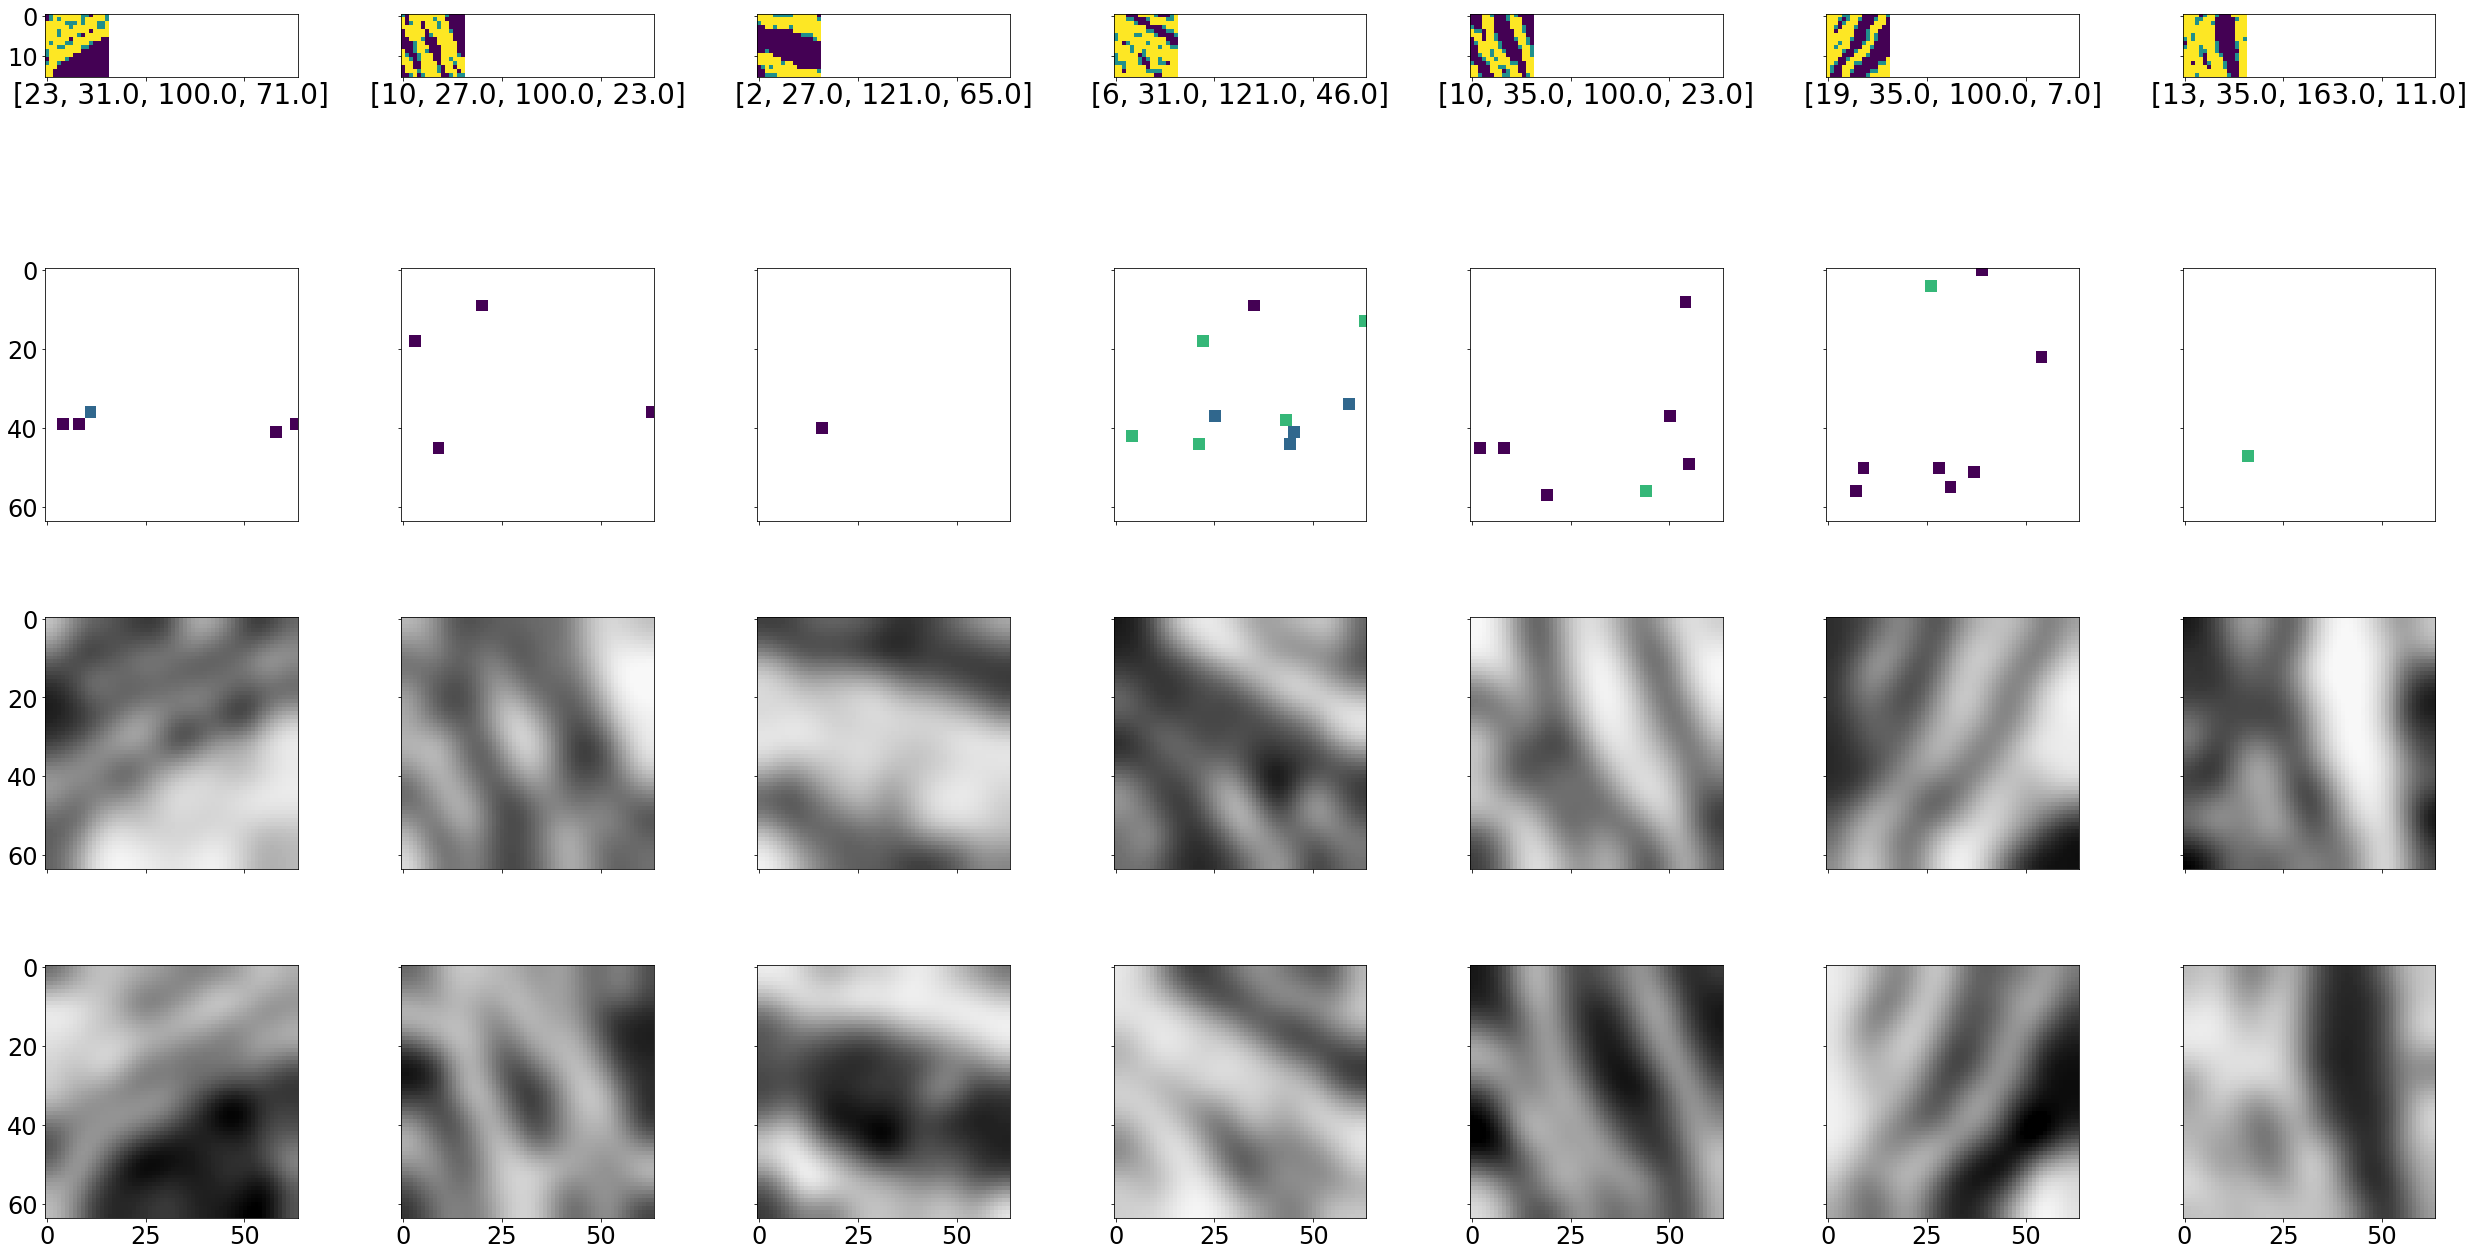

In [29]:
# Set larger font for readability
plt.rcParams.update({'font.size': 24})

# Create 4-row × 7-column figure layout
fig, ax = plt.subplots(4, 7, sharex='col', sharey='row')
fig.set_size_inches(35, 20, forward=True)

# Loop through 7 test examples (index 1 to 7)
for i in range(1, 8):
    # Plot facies map
    ax[0, i-1].imshow(facies_test[i, 0])
    
    # Get denormalized labels
    orient = int(orit_class[i])
    width_val = round(width[i], 1)
    wvl_val = round(wvl[i], 1)
    amplt_val = round(amplt[i], 1)
    
    # Set label as: [OrientClass, Width, Wavelength, Amplitude]
    ax[0, i-1].set_xlabel(
        f"[{orient}, {width_val}, {wvl_val}, {amplt_val}]",
        fontsize=28
    )

# Plot well facies
for i in range(1, 8):
    ax[1, i-1].imshow(wellfacies_onechannel_mask[i, 0], cmap=cmap_well, vmin=1, vmax=4)

# Plot channel probability
for i in range(1, 8):
    ax[2, i-1].imshow(probimgs_test[i, 0].astype(np.float32), vmin=0, vmax=0.7, cmap='gray_r')

# Plot mud probability
for i in range(1, 8):
    ax[3, i-1].imshow(probimgs_test[i, 1].astype(np.float32), vmin=0, vmax=0.7, cmap='gray_r')

# Save figure (optional)
# plt.savefig(data_dir + "Training_data_examples_channel_case.png", dpi=200)

plt.tight_layout()
plt.show()


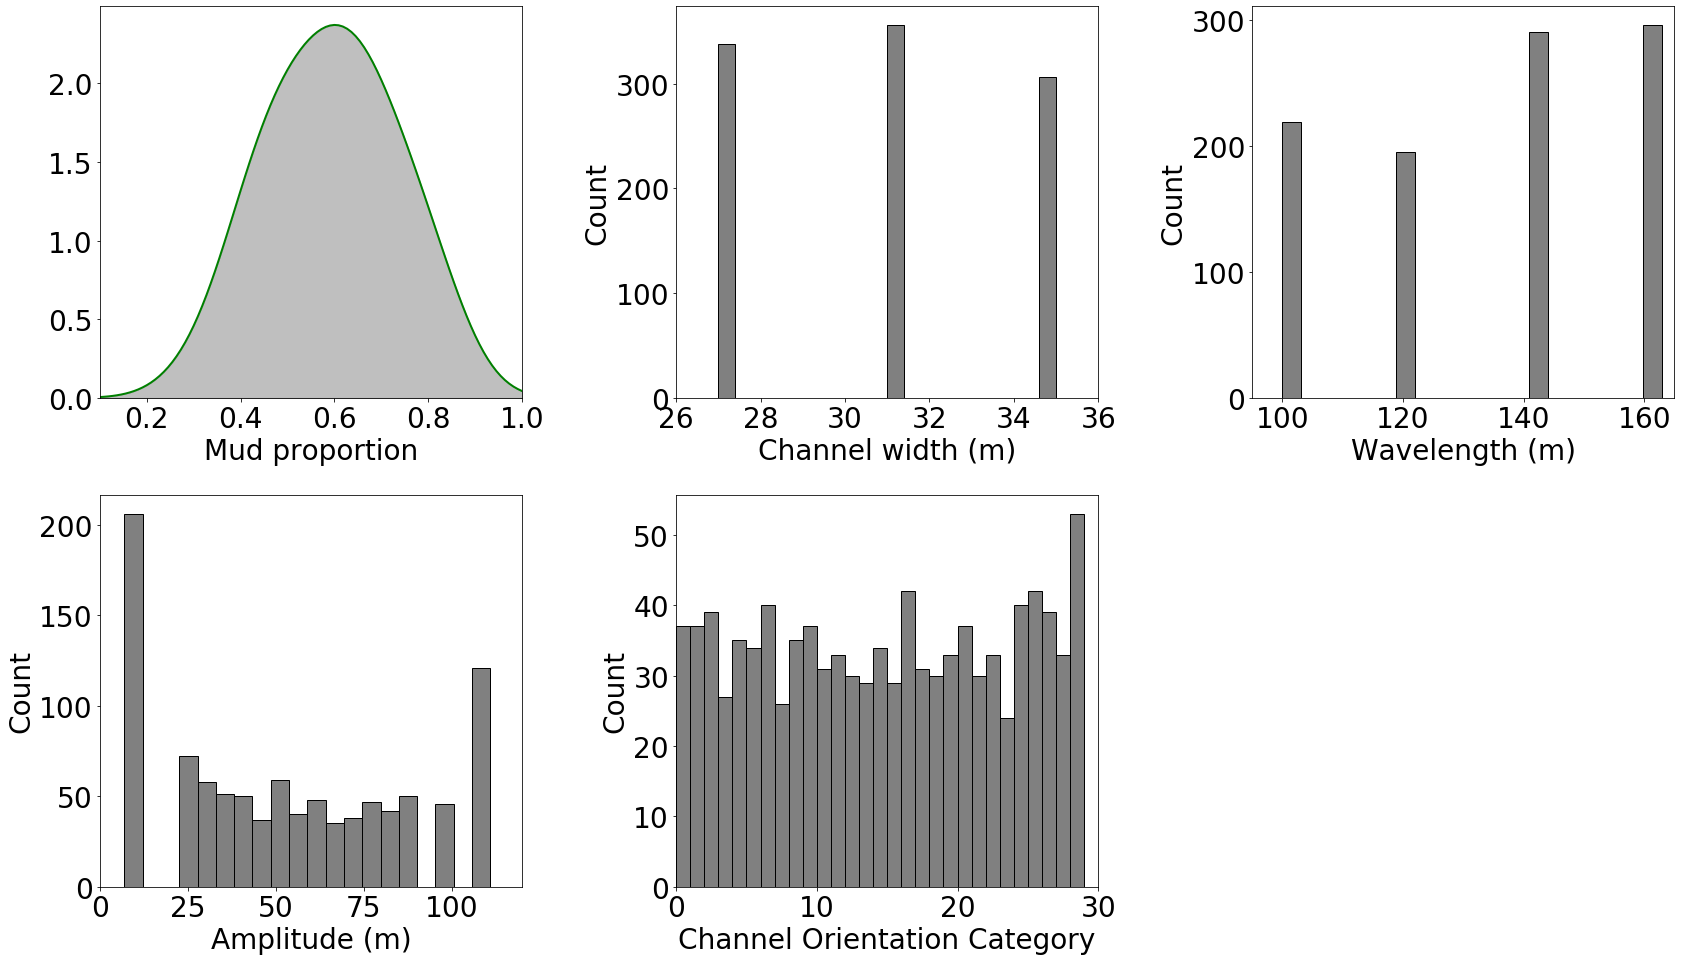

In [30]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np

plt.rcParams.update({'font.size': 28})

fig, ax = plt.subplots(2, 3)
fig.set_size_inches(24, 14, forward=True)

# ---------------------- Mud Proportion (Smoothed) ----------------------
x_range = np.linspace(0.1, 1.0, 100)
kde = gaussian_kde(mudprop, bw_method=0.5)
pdf_values = kde(x_range)

ax[0, 0].plot(x_range, pdf_values, 'g', linewidth=2, label='Mud proportion')
ax[0, 0].fill_between(x_range, pdf_values, color='gray', alpha=0.5)
ax[0, 0].set_ylim(bottom=0)
ax[0, 0].set_xlim(0.1, 1.0)
ax[0, 0].set_xlabel('Mud proportion')

# ---------------------- Channel Width (Histogram) ----------------------
ax[0, 1].hist(width, bins=20, color='gray', edgecolor='black')
ax[0, 1].set_xlim(26, 36)
ax[0, 1].set_xlabel('Channel width (m)')
ax[0, 1].set_ylabel('Count')

# ---------------------- Wavelength (Histogram) ----------------------
ax[0, 2].hist(wvl, bins=20, color='gray', edgecolor='black')
ax[0, 2].set_xlim(95, 165)
ax[0, 2].set_xlabel('Wavelength (m)')
ax[0, 2].set_ylabel('Count')

# ---------------------- Amplitude (Histogram) ----------------------
ax[1, 0].hist(amplt, bins=20, color='gray', edgecolor='black')
ax[1, 0].set_xlim(0, 120)
ax[1, 0].set_xlabel('Amplitude (m)')
ax[1, 0].set_ylabel('Count')

# ---------------------- Orientation (Histogram from Orientation Category) ----------------------
ax[1, 1].hist(orit_class, bins=np.arange(0, 30, 1), color='gray', edgecolor='black')
ax[1, 1].set_xlim(0, 30)
ax[1, 1].set_xlabel('Channel Orientation Category')
ax[1, 1].set_ylabel('Count')

# ---------------------- Empty plot slot ----------------------
ax[1, 2].axis('off')

# Final layout
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.tight_layout()

# Save figure (optional)
# plt.savefig(data_dir + "ChannelCase_HybridGlobalFeaturePlots.png", dpi=100)

plt.show()


### 3. Visualize training dataset with original resolutions

*if tfrecord_dir='TestData', then test dataset will be loaded; if tfrecord_dir = 'TrainingData', then training dataset will be loaded*

In [31]:
tf.InteractiveSession()

import dataset


test_set = dataset.load_dataset(data_dir=data_dir, verbose=True, tfrecord_dir='TrainingData', 
                                 cond_label = True, cond_well = True, cond_prob = True,
                                 well_enlarge = False, shuffle_mb = 0, prefetch_mb = 0)

# Note: labels are from -1 to 1
test_dict = test_set.get_minibatch_np(minibatch_size = 1000, lod = 0)  
facies_test = test_dict['real']
labels_test = test_dict['label']
probimgs_test = test_dict['prob']
wellfaciesimgs_test = test_dict['well']

print("Facies images shape:", facies_test.shape)
print("Labels shape:", labels_test.shape)
print("Probability maps shape:", probimgs_test.shape)
print("Well facies shape:", wellfaciesimgs_test.shape)

/share/software/user/open/py-tensorflow/2.6.2_py36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Streaming data using dataset.TFRecordDataset...
Dataset shape = [1, 64, 64]
Dynamic range = [0, 2]
Label size    = 0
Facies images shape: (1000, 1, 64, 64)
Labels shape: (1000, 34)
Probability maps shape: (1000, 2, 64, 64)
Well facies shape: (1000, 1, 64, 64)


#### Denormalize global features

In [32]:
# Extract orientation category from one-hot encoding (first 30 columns)
orit_one_hot = labels_test[:, :30]
orit_class = np.argmax(orit_one_hot, axis=1)

# Extract and denormalize mud proportion
mudprop = labels_test[:, 30]  # Normalized to [-1, 1]
mudprop = (mudprop / 2 + 0.5) * 0.8037 + 0.1677  # Original range: ~[0.1677, 0.9714]

# Extract and denormalize channel width
width = labels_test[:, 31]  # Normalized to [-1, 1]
width = (width / 2 + 0.5) * 8 + 27  # Original range: [27, 35]

# Extract and denormalize channel wavelength
wvl = labels_test[:, 32]  # Normalized to [-1, 1]
wvl = (wvl / 2 + 0.5) * 63 + 100  # Original range: [100, 163]

# Extract and denormalize channel amplitude
amplt = labels_test[:, 33]  # Normalized to [-1, 1]
amplt = (amplt / 2 + 0.5) * 104 + 7  # Original range: [7, 111]


#### Display obtained dataset

In [33]:
### Enlarge areas of well points only for better display ###

def enlarge(well_facies):
    ### Enlarge areas of well points into 4 x 4 as inputs
    with tf.device('/gpu:0'):
        well_facies = tf.cast(well_facies, tf.float32)
        well_facies_enlarge = tf.nn.max_pool(well_facies, ksize = [1,1,3,3], strides=[1,1,1,1], padding='SAME', data_format='NCHW') 
    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        well_points_el = sess.run(well_facies_enlarge) 
    return well_points_el

wellfacies_onechannel = enlarge(wellfaciesimgs_test)
wellfacies_onechannel_mask = np.ma.masked_where(wellfacies_onechannel == 0, wellfacies_onechannel)
cmap_well = plt.cm.viridis  
cmap_well.set_bad(color='white')

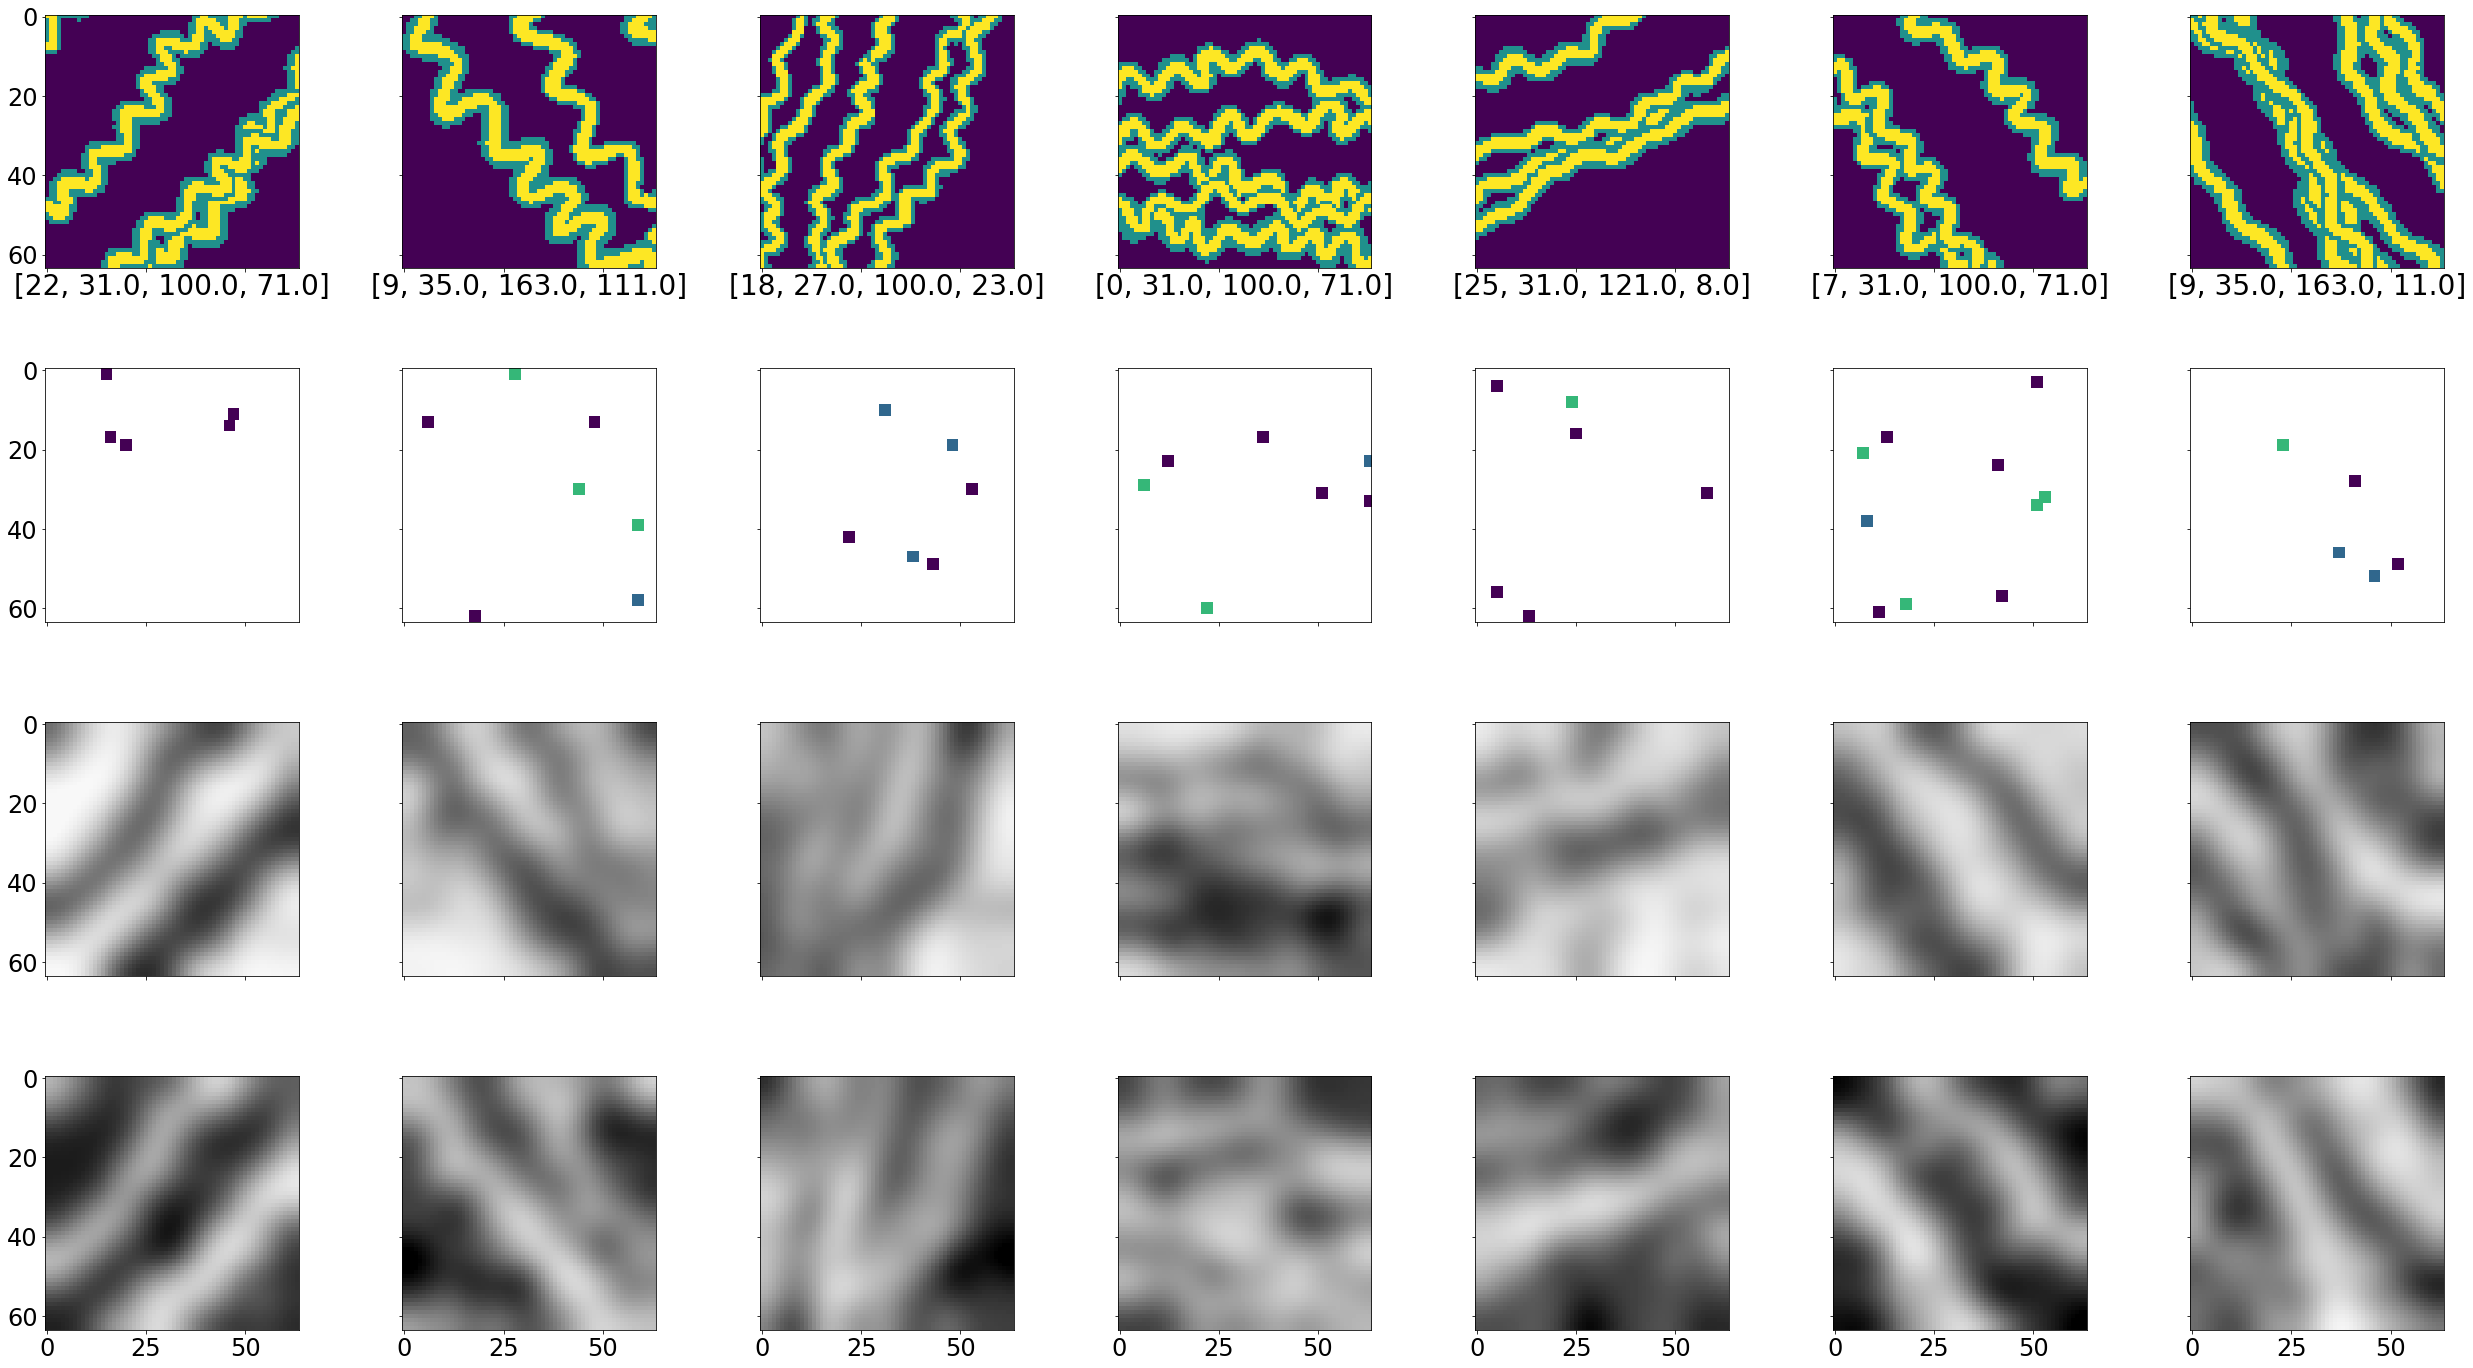

In [34]:
# Set larger font for readability
plt.rcParams.update({'font.size': 24})

# Create 4-row × 7-column figure layout
fig, ax = plt.subplots(4, 7, sharex='col', sharey='row')
fig.set_size_inches(35, 20, forward=True)

# Loop through 7 test examples (index 1 to 7)
for i in range(1, 8):
    # Plot facies map
    ax[0, i-1].imshow(facies_test[i, 0])
    
    # Get denormalized labels
    orient = int(orit_class[i])
    width_val = round(width[i], 1)
    wvl_val = round(wvl[i], 1)
    amplt_val = round(amplt[i], 1)
    
    # Set label as: [OrientClass, Width, Wavelength, Amplitude]
    ax[0, i-1].set_xlabel(
        f"[{orient}, {width_val}, {wvl_val}, {amplt_val}]",
        fontsize=28
    )

# Plot well facies
for i in range(1, 8):
    ax[1, i-1].imshow(wellfacies_onechannel_mask[i, 0], cmap=cmap_well, vmin=1, vmax=4)

# Plot channel probability
for i in range(1, 8):
    ax[2, i-1].imshow(probimgs_test[i, 0].astype(np.float32), vmin=0, vmax=0.7, cmap='gray_r')

# Plot mud probability
for i in range(1, 8):
    ax[3, i-1].imshow(probimgs_test[i, 1].astype(np.float32), vmin=0, vmax=0.7, cmap='gray_r')

# Save figure (optional)
# plt.savefig(data_dir + "Training_data_examples_channel_case.png", dpi=200)

plt.tight_layout()
plt.show()


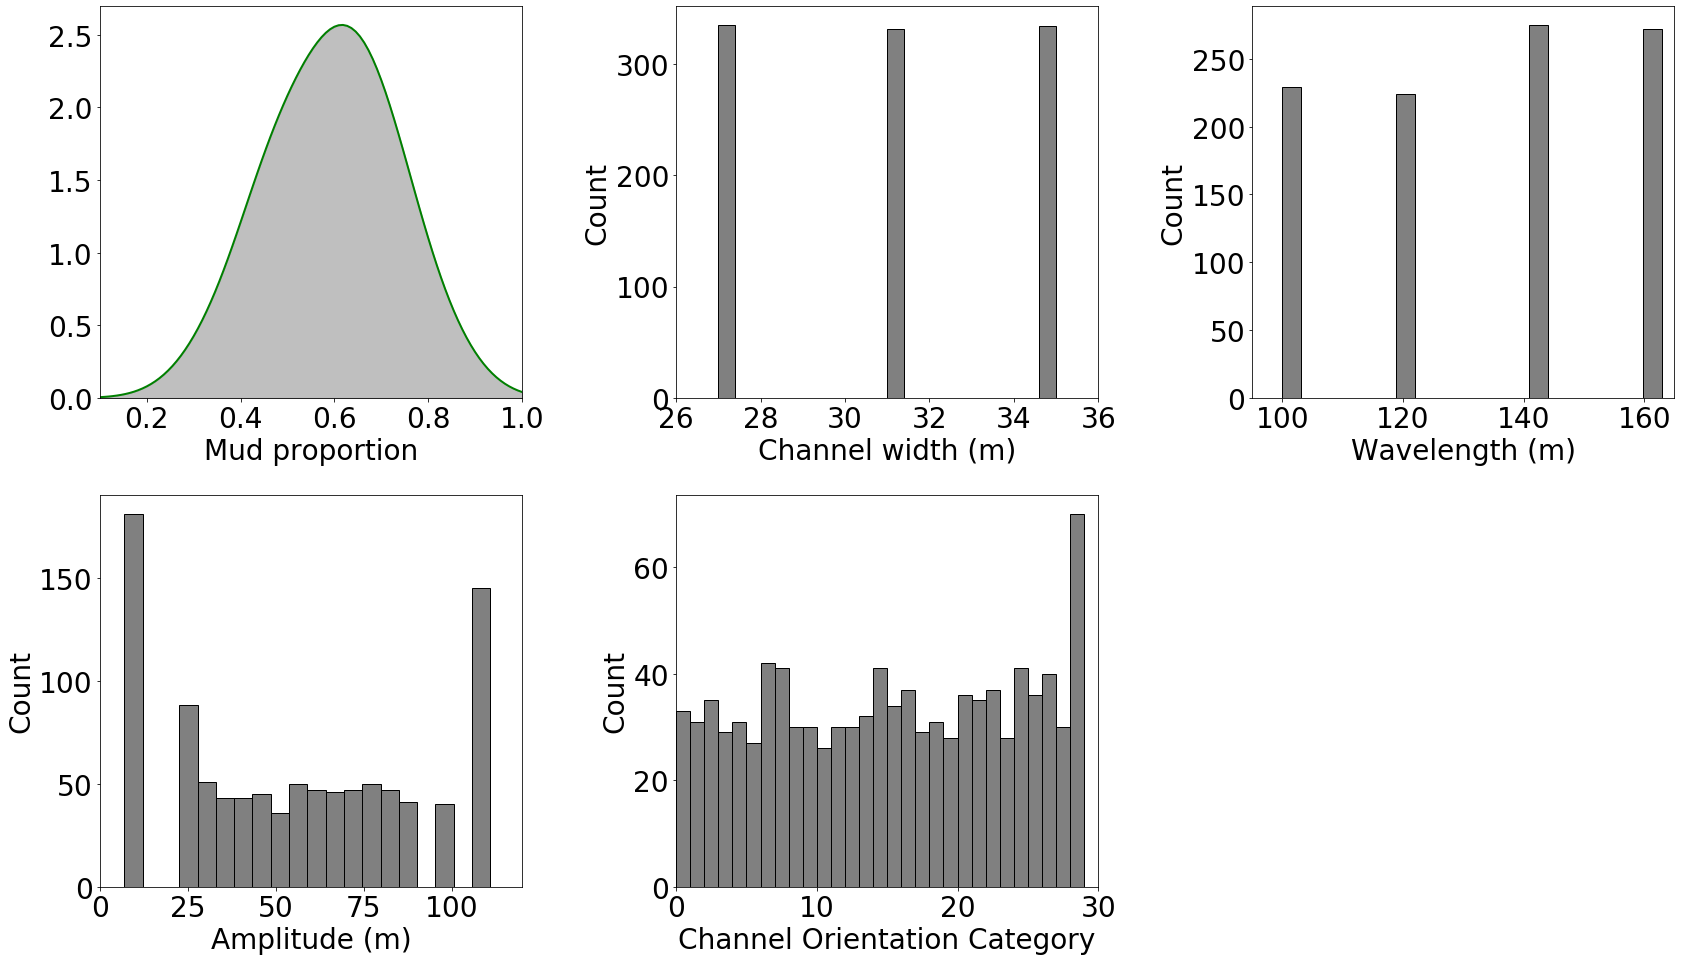

In [35]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np

plt.rcParams.update({'font.size': 28})

fig, ax = plt.subplots(2, 3)
fig.set_size_inches(24, 14, forward=True)

# ---------------------- Mud Proportion (Smoothed) ----------------------
x_range = np.linspace(0.1, 1.0, 100)
kde = gaussian_kde(mudprop, bw_method=0.5)
pdf_values = kde(x_range)

ax[0, 0].plot(x_range, pdf_values, 'g', linewidth=2, label='Mud proportion')
ax[0, 0].fill_between(x_range, pdf_values, color='gray', alpha=0.5)
ax[0, 0].set_ylim(bottom=0)
ax[0, 0].set_xlim(0.1, 1.0)
ax[0, 0].set_xlabel('Mud proportion')

# ---------------------- Channel Width (Histogram) ----------------------
ax[0, 1].hist(width, bins=20, color='gray', edgecolor='black')
ax[0, 1].set_xlim(26, 36)
ax[0, 1].set_xlabel('Channel width (m)')
ax[0, 1].set_ylabel('Count')

# ---------------------- Wavelength (Histogram) ----------------------
ax[0, 2].hist(wvl, bins=20, color='gray', edgecolor='black')
ax[0, 2].set_xlim(95, 165)
ax[0, 2].set_xlabel('Wavelength (m)')
ax[0, 2].set_ylabel('Count')

# ---------------------- Amplitude (Histogram) ----------------------
ax[1, 0].hist(amplt, bins=20, color='gray', edgecolor='black')
ax[1, 0].set_xlim(0, 120)
ax[1, 0].set_xlabel('Amplitude (m)')
ax[1, 0].set_ylabel('Count')

# ---------------------- Orientation (Histogram from Orientation Category) ----------------------
ax[1, 1].hist(orit_class, bins=np.arange(0, 30, 1), color='gray', edgecolor='black')
ax[1, 1].set_xlim(0, 30)
ax[1, 1].set_xlabel('Channel Orientation Category')
ax[1, 1].set_ylabel('Count')

# ---------------------- Empty plot slot ----------------------
ax[1, 2].axis('off')

# Final layout
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.tight_layout()

# Save figure (optional)
# plt.savefig(data_dir + "ChannelCase_HybridGlobalFeaturePlots.png", dpi=100)

plt.show()


### 4. Visualize training dataset with coarser resolutions (16x16)

*if tfrecord_dir='TestData', then test dataset will be loaded; if tfrecord_dir = 'TrainingData', then training dataset will be loaded*

In [36]:
tf.InteractiveSession()

import dataset


test_set = dataset.load_dataset(data_dir=data_dir, verbose=True, tfrecord_dir='TrainingData', 
                                 cond_label = True, cond_well = True, cond_prob = True,
                                 well_enlarge = False, shuffle_mb = 0, prefetch_mb = 0)

# Note: labels are from -1 to 1
test_dict = test_set.get_minibatch_np(minibatch_size = 1000, lod = 2)  
facies_test = test_dict['real']
labels_test = test_dict['label']
probimgs_test = test_dict['prob']
wellfaciesimgs_test = test_dict['well']

print("Facies images shape:", facies_test.shape)
print("Labels shape:", labels_test.shape)
print("Probability maps shape:", probimgs_test.shape)
print("Well facies shape:", wellfaciesimgs_test.shape)

/share/software/user/open/py-tensorflow/2.6.2_py36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Streaming data using dataset.TFRecordDataset...
Dataset shape = [1, 64, 64]
Dynamic range = [0, 2]
Label size    = 0
Facies images shape: (1000, 1, 16, 16)
Labels shape: (1000, 34)
Probability maps shape: (1000, 2, 64, 64)
Well facies shape: (1000, 1, 64, 64)


#### Denormalize global features

In [37]:
# Extract orientation category from one-hot encoding (first 30 columns)
orit_one_hot = labels_test[:, :30]
orit_class = np.argmax(orit_one_hot, axis=1)

# Extract and denormalize mud proportion
mudprop = labels_test[:, 30]  # Normalized to [-1, 1]
mudprop = (mudprop / 2 + 0.5) * 0.8037 + 0.1677  # Original range: ~[0.1677, 0.9714]

# Extract and denormalize channel width
width = labels_test[:, 31]  # Normalized to [-1, 1]
width = (width / 2 + 0.5) * 8 + 27  # Original range: [27, 35]

# Extract and denormalize channel wavelength
wvl = labels_test[:, 32]  # Normalized to [-1, 1]
wvl = (wvl / 2 + 0.5) * 63 + 100  # Original range: [100, 163]

# Extract and denormalize channel amplitude
amplt = labels_test[:, 33]  # Normalized to [-1, 1]
amplt = (amplt / 2 + 0.5) * 104 + 7  # Original range: [7, 111]


#### Display obtained dataset

In [38]:
### Enlarge areas of well points only for better display ###

def enlarge(well_facies):
    ### Enlarge areas of well points into 4 x 4 as inputs
    with tf.device('/gpu:0'):
        well_facies = tf.cast(well_facies, tf.float32)
        well_facies_enlarge = tf.nn.max_pool(well_facies, ksize = [1,1,3,3], strides=[1,1,1,1], padding='SAME', data_format='NCHW') 
    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        well_points_el = sess.run(well_facies_enlarge) 
    return well_points_el

wellfacies_onechannel = enlarge(wellfaciesimgs_test)
wellfacies_onechannel_mask = np.ma.masked_where(wellfacies_onechannel == 0, wellfacies_onechannel)
cmap_well = plt.cm.viridis  
cmap_well.set_bad(color='white')

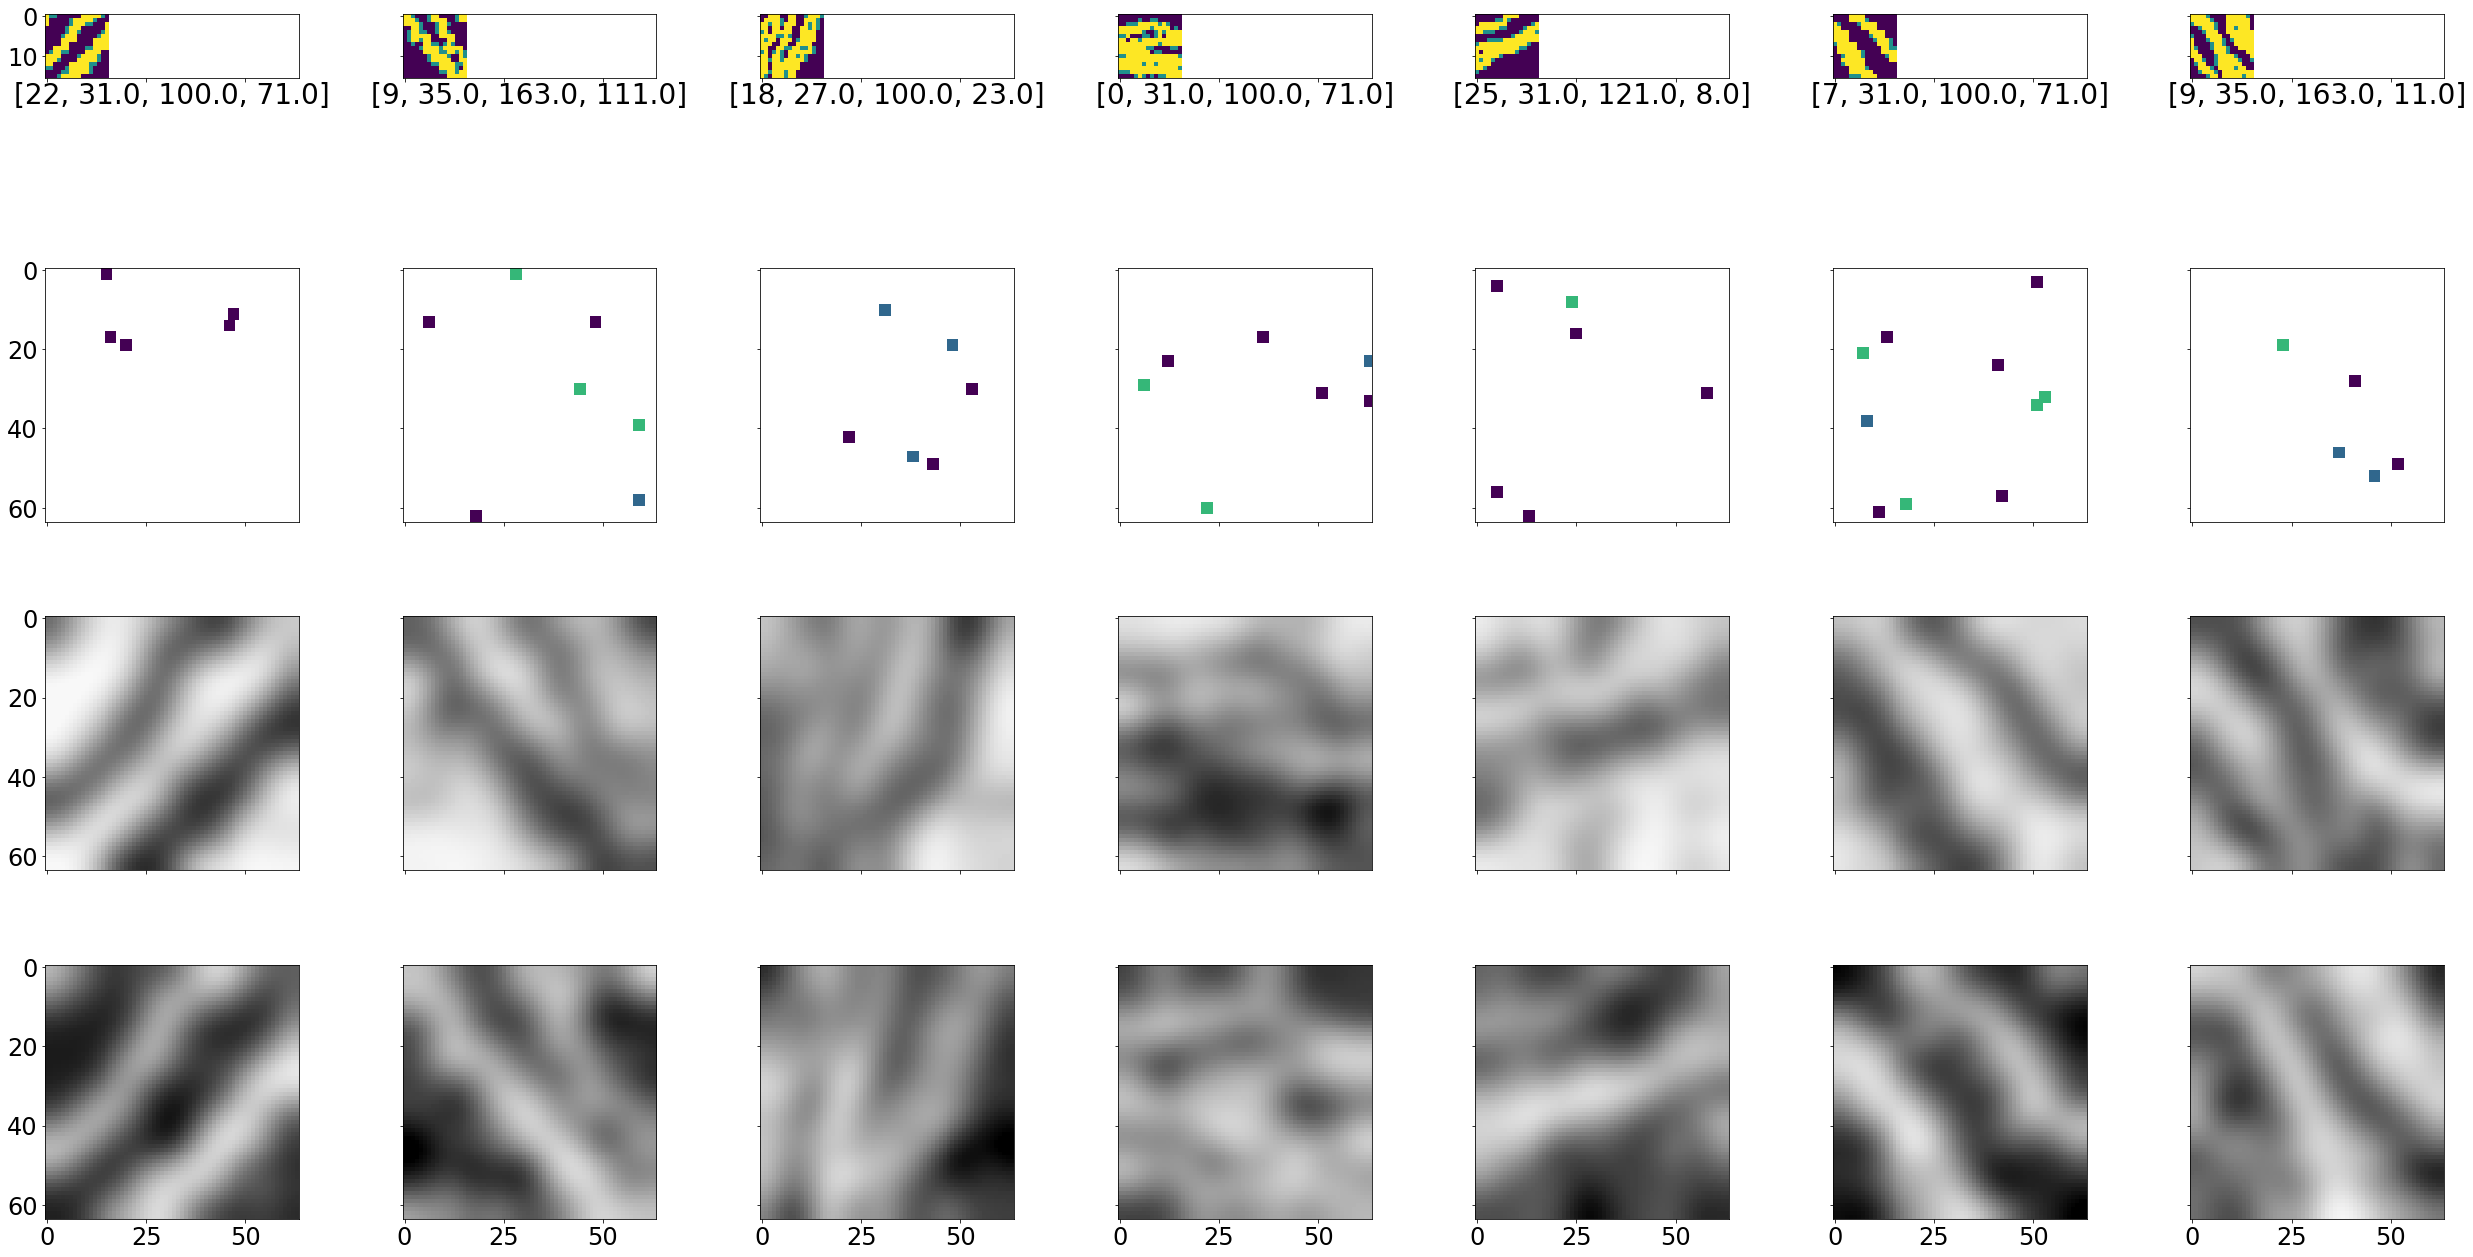

In [39]:
# Set larger font for readability
plt.rcParams.update({'font.size': 24})

# Create 4-row × 7-column figure layout
fig, ax = plt.subplots(4, 7, sharex='col', sharey='row')
fig.set_size_inches(35, 20, forward=True)

# Loop through 7 test examples (index 1 to 7)
for i in range(1, 8):
    # Plot facies map
    ax[0, i-1].imshow(facies_test[i, 0])
    
    # Get denormalized labels
    orient = int(orit_class[i])
    width_val = round(width[i], 1)
    wvl_val = round(wvl[i], 1)
    amplt_val = round(amplt[i], 1)
    
    # Set label as: [OrientClass, Width, Wavelength, Amplitude]
    ax[0, i-1].set_xlabel(
        f"[{orient}, {width_val}, {wvl_val}, {amplt_val}]",
        fontsize=28
    )

# Plot well facies
for i in range(1, 8):
    ax[1, i-1].imshow(wellfacies_onechannel_mask[i, 0], cmap=cmap_well, vmin=1, vmax=4)

# Plot channel probability
for i in range(1, 8):
    ax[2, i-1].imshow(probimgs_test[i, 0].astype(np.float32), vmin=0, vmax=0.7, cmap='gray_r')

# Plot mud probability
for i in range(1, 8):
    ax[3, i-1].imshow(probimgs_test[i, 1].astype(np.float32), vmin=0, vmax=0.7, cmap='gray_r')

# Save figure (optional)
# plt.savefig(data_dir + "Training_data_examples_channel_case.png", dpi=200)

plt.tight_layout()
plt.show()


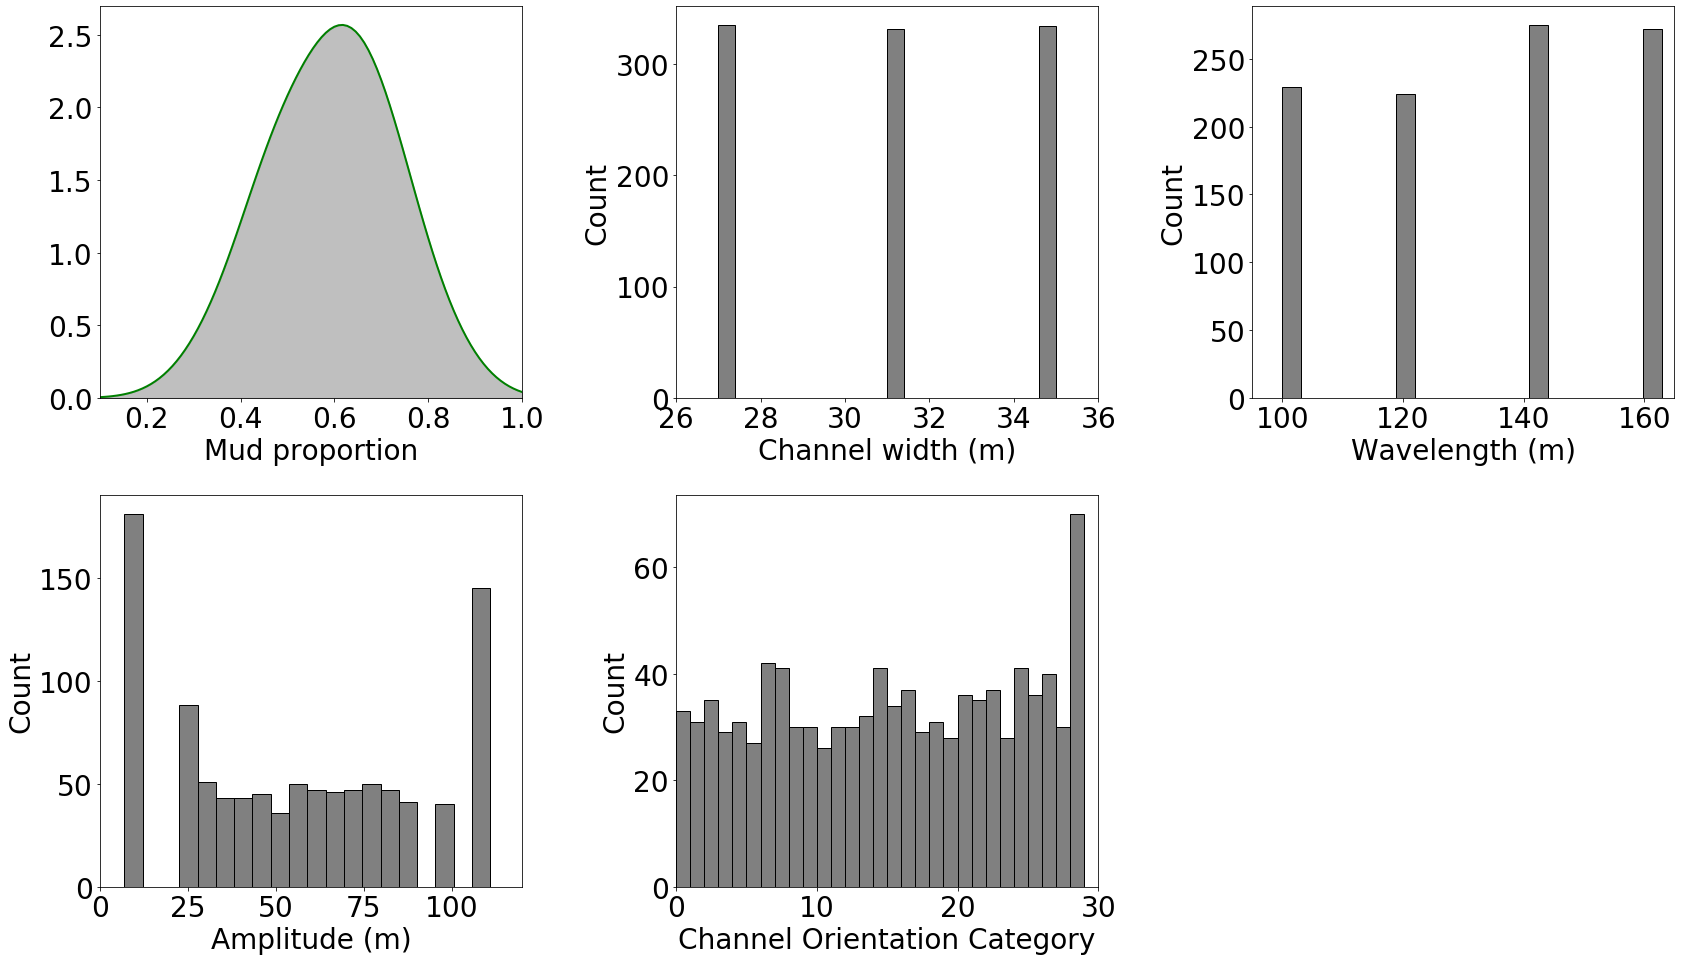

In [40]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np

plt.rcParams.update({'font.size': 28})

fig, ax = plt.subplots(2, 3)
fig.set_size_inches(24, 14, forward=True)

# ---------------------- Mud Proportion (Smoothed) ----------------------
x_range = np.linspace(0.1, 1.0, 100)
kde = gaussian_kde(mudprop, bw_method=0.5)
pdf_values = kde(x_range)

ax[0, 0].plot(x_range, pdf_values, 'g', linewidth=2, label='Mud proportion')
ax[0, 0].fill_between(x_range, pdf_values, color='gray', alpha=0.5)
ax[0, 0].set_ylim(bottom=0)
ax[0, 0].set_xlim(0.1, 1.0)
ax[0, 0].set_xlabel('Mud proportion')

# ---------------------- Channel Width (Histogram) ----------------------
ax[0, 1].hist(width, bins=20, color='gray', edgecolor='black')
ax[0, 1].set_xlim(26, 36)
ax[0, 1].set_xlabel('Channel width (m)')
ax[0, 1].set_ylabel('Count')

# ---------------------- Wavelength (Histogram) ----------------------
ax[0, 2].hist(wvl, bins=20, color='gray', edgecolor='black')
ax[0, 2].set_xlim(95, 165)
ax[0, 2].set_xlabel('Wavelength (m)')
ax[0, 2].set_ylabel('Count')

# ---------------------- Amplitude (Histogram) ----------------------
ax[1, 0].hist(amplt, bins=20, color='gray', edgecolor='black')
ax[1, 0].set_xlim(0, 120)
ax[1, 0].set_xlabel('Amplitude (m)')
ax[1, 0].set_ylabel('Count')

# ---------------------- Orientation (Histogram from Orientation Category) ----------------------
ax[1, 1].hist(orit_class, bins=np.arange(0, 30, 1), color='gray', edgecolor='black')
ax[1, 1].set_xlim(0, 30)
ax[1, 1].set_xlabel('Channel Orientation Category')
ax[1, 1].set_ylabel('Count')

# ---------------------- Empty plot slot ----------------------
ax[1, 2].axis('off')

# Final layout
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.tight_layout()

# Save figure (optional)
# plt.savefig(data_dir + "ChannelCase_HybridGlobalFeaturePlots.png", dpi=100)

plt.show()
